## Desafío - Inferencia de tópicos con EM
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
        - El desafío se debe desarrollar de manera Individual.
        - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío Inferencia de tópicos con EM.

### Requerimientos
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se    encuentra en la carpeta dump.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
- Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las
  buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
  múltiples archivos dentro de la carpeta dump.
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en
  dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas.
  Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.


In [1]:
# Triada calsica.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Graficos seaborn, warnings y datos perdidos.
import seaborn as sns
import warnings
import missingno as msngo

# Importaciones especificas de este desafio.
import glob, os

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Otras librerias, configuraciones e instancias.
labelencoder = LabelEncoder()
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('seaborn-darkgrid')

In [2]:
csv_list = glob.glob('Datasets/dump/*.csv')
name_csv = []

In [3]:
for i in csv_list:
        name_csv.append(pd.read_csv(i, index_col = None, header = 0).drop(columns = 'Unnamed: 0'))

df_letras = pd.concat(name_csv)
df_letras.columns = ['Artista', 'Genero', 'Cancion', 'Letra']

In [4]:
df_letras.head()

,Artista,Genero,Cancion,Letra
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


### Ejercicio 2: Matriz de ocurrencias
- Importe la clase CountVectorizer dentro de los módulos
  feature_extraction.text de la librería sklearn.
- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de
  datos.
- Con la clase inicializada, incorpore las letras con el método fit_transform y guarde
  los resultados en un nuevo objeto.

In [5]:
# instanciamos un objeto CountVectorizer()
count_vectorizer = CountVectorizer(stop_words = 'english')

In [6]:
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df_letras.Letra)

In [7]:
# Extraemos tokens (palabras)
words  = count_vectorizer.get_feature_names()
words[:10]

['00', '000', '007', '01', '019', '02', '0281', '03', '04', '05']

In [8]:
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis = 0)
words_freq[:10]

array([14, 42,  2, 13,  3,  3,  1,  4,  3,  5], dtype=int64)

In [9]:
# creamos un nuevo dataframe
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T
words_freq_df.head()

,0,1
0,00,14
1,000,42
2,007,2
3,01,13
4,019,3


In [10]:
words_freq_df.columns= ['word', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending = False).iloc[0:5000, :]
words_freq_df.head()

,word,freq
24950,like,19629
12859,don,17398
23856,know,14962
18439,got,14171
23287,just,13978


### Ejercicio 3: Entrenamiento del Modelo
- Importe sklearn.decomposition.LatentDirichletAllocation y
  sklearn.model_selection.GridSearchCV.
- Genere una búsqueda de grilla con los siguientes hiper parámetros:
        - n_components: [5, 10, 15].
        - learning_decay: [0.7, 0.5].
- Entrene la búsqueda de grilla con las letras en un formato vectorizado con
  CountVectorizer.
- Reporte brevemente cuál es la mejor combinación de hiper parámetros.

#### Digresión: Latent Dirichlet Allocation
Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia
Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de
texto. El proceso de inferencia se puede resumir en los siguientes pasos:

- Cada documento dentro del corpus se puede entender como una mezcla de tópicos
  comunes a nivel de corpus.
- Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y
  sus palabras.
La API de sklearn.decomposition.LatentDirichletAllocation presenta la
misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la
inicialización de la clase son:

  - n_components: Cantidad de tópicos a inferir en un corpus.
  - learning_method: Forma en la que entran los datos en entrenamiento.
    Cuando es 'batch', se ingresa la matriz de entrenamiento completa. Cuando
    es 'online', la matriz de entrenamiento ingresa de manera secuencial en
    parcelas pequeñas.
  - learning_decay: Tasa de aprendizaje en la función de pérdida. Cuando se
    implementa con learning_method='online', el modelo se entrena con
    Gradiente Estocástico Descendente.
  - Perplejidad: Busca aproximar el número óptimo de tópicos a inferir.
    Técnicamente evalúa qué tan bien predice una muestra específica. En función
    a un número de tópicos, define la distribución teórica de palabras
    representada por los tópicos y la compara con la ocurrencia empírica de
    palabras en tópicos.


In [11]:
param_grid = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}

In [12]:
lda = LatentDirichletAllocation()
#lda.fit()

In [13]:
# n_jobs = -1 significa usar todos los procesadores disponiobles
# verbose = 3 significa que los índices de parámetros de 
# pliegue y candidato también se muestran junto con la hora de inicio del cálculo.
# cv significa las validaciones cruzadas a realizar
model_gridcv = GridSearchCV(lda, param_grid, cv = 5, n_jobs = -1, verbose = 3)

In [14]:
model_gridcv.fit(count_vectorizer_fit)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]},
             verbose=3)

In [15]:
print(f'''
Mejores hiper parametros: {model_gridcv.best_params_}
Mejor Puntaje: {model_gridcv.best_score_}''')


Mejores hiper parametros: {'learning_decay': 0.5, 'n_components': 5}
Mejor Puntaje: -2577570.389652352


### Ejercicio 4 : Inferencia e Identificación de Tópicos
- En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz
  de atributos de las letras.
- Para identificar de qué se trata cada tópico, necesitamos identificar las principales
  15 palabras asociadas con éste. Puede implementar la siguiente línea de código para
  identificar las principales palabras en un tópico:

In [16]:
count_vectorizer_i = CountVectorizer(stop_words = 'english')

In [17]:

count = count_vectorizer_i.fit_transform(df_letras.Letra)

In [18]:
# n_jobs = -1 significa usar todos los procesadores disponibles
# verbose = 3 significa que los índices de parámetros de 
# pliegue y candidato también se muestran junto con la hora de inicio del cálculo.
# cv significa las validaciones cruzadas a realizar
model_gridcv_i = GridSearchCV(lda, {'n_components': [5], 'learning_decay': [0.7]}, cv = 5, n_jobs = -1, verbose = 3)

In [19]:
model_gridcv_i.fit(count)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.7], 'n_components': [5]},
             verbose=3)

In [20]:
print(f'''
Mejores hiper parametros: {model_gridcv_i.best_params_}
Mejor Puntaje: {model_gridcv_i.best_score_}''')


Mejores hiper parametros: {'learning_decay': 0.7, 'n_components': 5}
Mejor Puntaje: -2581732.7589787445


In [21]:
best_estimator = model_gridcv_i.best_estimator_
best_estimator 

LatentDirichletAllocation(n_components=5)

In [22]:

# mediante .components_ podemos extraer una matriz que entrega las
# distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_estimator.components_):
        # para cada tópico
        print("tópico: {}".format(topic_id + 1))
        # mediante argsort logramos ordenar los elementos por magnitud
        # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
        # en la matriz dispersa y devolvemos el nombre.
        # finalmente concatenamos las palabras
        print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
don love know just yeah oh ll baby like got let want ve time come
tópico: 2
like got shit don ain yo know nigga fuck man em cause just ya niggas
tópico: 3
oh like just home got yeah said little man know ll night come old don
tópico: 4
ah don man like know yeah cause ma got doo song say people future tell
tópico: 5
death life god world blood die dead eyes time light na ll soul pain day


In [23]:
# Vista de clases
df_letras['Genero'].unique()

array(['metal', 'hiphop', 'rock', 'pop'], dtype=object)

- Comente a qué tópicos está asociada cada clase inferida.

### Ejercicio 5: Identificación de probabilidades
- En base a la información generada, es posible identificar cuales van a ser los géneros
  más probables de ocurrir para un artista.
- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de
  datos original. Podemos implementar esto de la siguiente manera:

In [24]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_estimator.transform(count_vectorizer_fit)
# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
# pasamos esta matriz y la redondeamos en 3 decimales
# agregamos un índice
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index = df_letras.index)
# agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_estimator.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_letras, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [25]:
# DataFrame con la probabilidad de los topicos para cada clase
concatenated_df.head()

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.094,0.004,0.089,0.004,0.810,5
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.004,0.004,0.530,0.004,0.457,3
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.528,0.002,0.467,0.002,0.002,1
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.624,0.082,0.003,0.003,0.288,1
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.174,0.003,0.003,0.003,0.818,5


In [26]:
concatenated_df.sample(50)

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
170,Raekwon,hiphop,The Red Carpet,"I set it off in the sunny distance, no days ex...",0.221,0.581,0.001,0.001,0.196,2
143,Kanye West,hiphop,Don't Look Down,"(Mos Def) \n Don't look down, it's an impossib...",0.375,0.255,0.160,0.104,0.106,1
111,Eminem,hiphop,The Sauce,"It's all bad now man, it's all bad \n It's all...",0.215,0.783,0.001,0.001,0.001,2
82,Public Enemy,hiphop,He Got Game,If man is the father then the son \n Is the ce...,0.268,0.464,0.001,0.137,0.131,2
30,Rage Against The Machine,rock,Testify,"Unfortunately, we are not licensed to display ...",0.017,0.017,0.017,0.933,0.017,4
18,Bob Dylan,rock,A Hard Rain's A-Gonna Fall,"Oh, where have you been \n My blue-eyed son? \...",0.323,0.001,0.386,0.023,0.267,3
61,Weezer,rock,Thought I Knew,Sorry about my past life \n Sorry but we just ...,0.992,0.002,0.002,0.002,0.002,1
133,Nicki Minaj,pop,Inspirations (Outro),"Capleton, Beenie Man, Mavado, uh oh \n Sizzla ...",0.096,0.428,0.003,0.189,0.284,2
79,Rush,rock,Turn The Page,Nothing can survive in a vacuum \n No one can ...,0.273,0.001,0.526,0.143,0.056,3
12,Faith No More,rock,Death March,"Washington boulevard, eastbound \n Thirty thre...",0.511,0.157,0.003,0.003,0.326,1


In [27]:
concatenated_df.tail()

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
246,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n...",0.134,0.003,0.357,0.003,0.503,5
247,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...,0.826,0.048,0.120,0.002,0.002,1
248,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...,0.880,0.005,0.005,0.105,0.005,1
249,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...,0.907,0.075,0.006,0.006,0.006,1
250,Weezer,rock,Zep Jamb,Alright \n Say baby \n Love me \n Lay your mon...,0.978,0.006,0.005,0.005,0.006,1


In [56]:
df_result_topic = concatenated_df[['Genero', 'T: 1', 'T: 2', 'T: 3', 'T: 4', 'T: 5']].groupby('Genero').mean().reset_index()
df_result_topic

,Genero,T: 1,T: 2,T: 3,T: 4,T: 5
0,hiphop,0.191378,0.648613,0.041749,0.061423,0.057040
1,metal,0.216912,0.033231,0.064734,0.041709,0.643435
2,pop,0.637730,0.170145,0.065926,0.063300,0.062950
3,rock,0.506741,0.052649,0.174155,0.114492,0.152018


In [32]:
def selec_df_artist(df, artista):
        return df[df['Artista'] == artista].loc[:, 'T: 1':'T: 5']

In [33]:
# extraemos probabilidades de tópicos para la banda Weezer
weezer_df = selec_df_artist(concatenated_df, 'Weezer')
weezer_df.shape

(251, 5)

<AxesSubplot:>

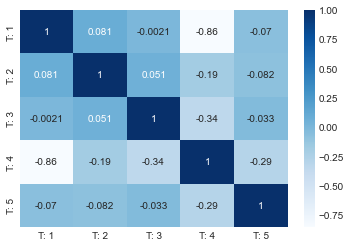

In [40]:
# Correlacion de topicos para la banda Weezer
sns.heatmap(weezer_df.corr(), annot=True, cmap='Blues')

In [50]:
weezer_df.mean()

T: 1    0.360522
T: 2    0.027518
T: 3    0.073080
T: 4    0.473100
T: 5    0.066295
dtype: float64

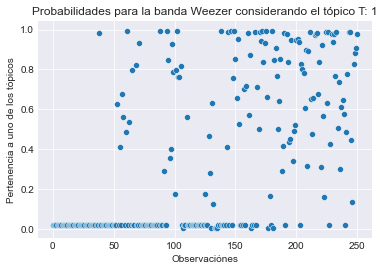

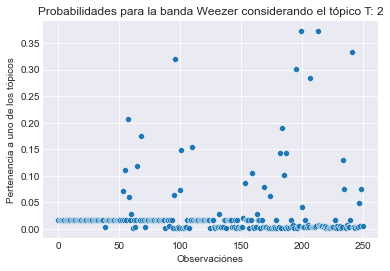

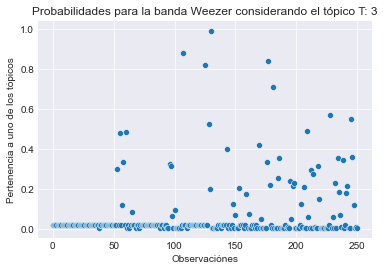

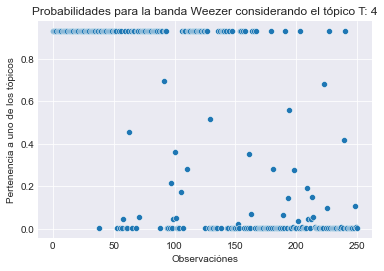

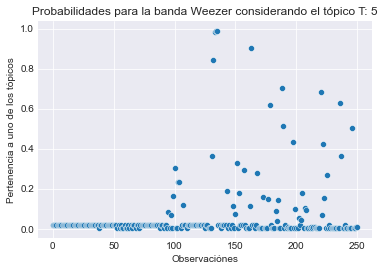

In [63]:
for col in weezer_df.columns:
        sns.scatterplot(data = weezer_df[col])
        plt.title(f'Probabilidades para la banda {"Weezer"} considerando el tópico {col}')
        plt.ylabel('Pertenencia a uno de los tópicos')
        plt.xlabel('Observaciónes')
        plt.show()

Se puede observar que la banda Weezer tiene mayor porcentaje de pertenencia a los topicos T: 1 y T: 4, y una mayor aglomeracion a la pertenencia del topico 4

In [37]:
meshuggah_df = selec_df_artist(concatenated_df, 'Meshuggah')
meshuggah_df.shape

(81, 5)

<AxesSubplot:>

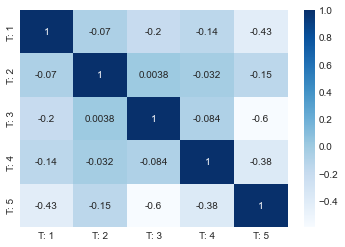

In [65]:
# Correlacion de topicos para la banda Meshuggah
sns.heatmap(meshuggah_df.corr(), annot=True, cmap='Blues')

In [38]:
meshuggah_df.mean()

T: 1    0.066494
T: 2    0.012654
T: 3    0.063309
T: 4    0.042025
T: 5    0.815519
dtype: float64

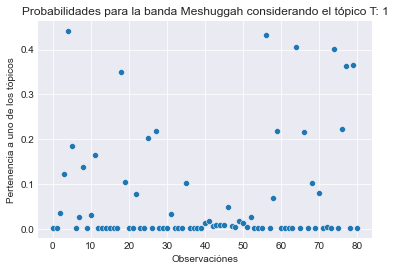

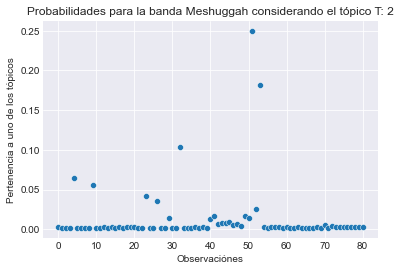

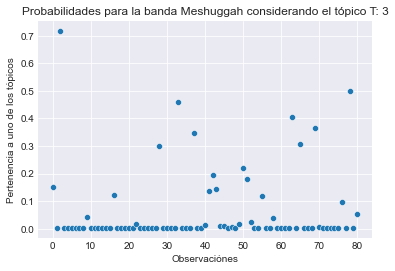

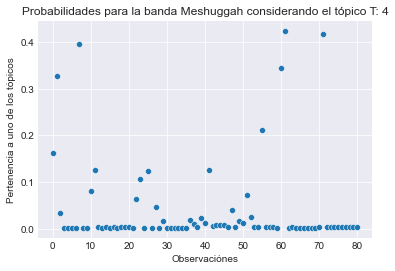

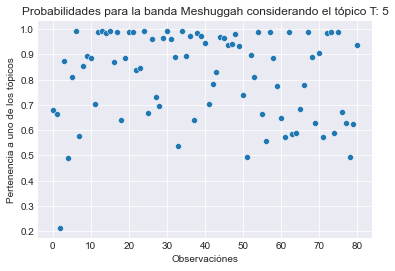

In [84]:
for col in meshuggah_df.columns:
        sns.scatterplot(data = meshuggah_df[col])
        plt.title(f'Probabilidades para la banda {"Meshuggah"} considerando el tópico {col}')
        plt.ylabel('Pertenencia a uno de los tópicos')
        plt.xlabel('Observaciónes')
        plt.show()

Se puede observar que la banda Meshuggah tiene mayor porcentaje de pertenencia al topico T: 5 y sin lugar a dudas corresponde al topico 5, lo que da un indicio de que el modelo es bueno prediciendo variables con pocos datos. En los graficos antes vistos podemos ver que si bien el modelo predice bien la ocurrencia para ambas bandas estudiadas, Meshuggah, que tiene mucho menos obsevaciones, presenta una clara tendencia al topico 5, mientras que Weezer tiende a pertenecer a los topicos T1 y T4, esto puede darse por que son cuatro las clases de nuestro seudo vector objetivo o variable a predecir en este caso Genero, y el modelo nos entrego un hiper parametro de n_component = 5 y por esta razon algunas bandas pueden tener rasgos de pertenencia a otras clases pero siempre con alguna tendencia al topico adecuado.